### Logistic Regression (LogRegChoice.ipynb)
Train a differentially private logistic regression model while trying to optimize the choice of the regularization hyperparameter.

Goal: See how a ChoiceMaker performs on "easier" DP problems where a
probabilistic bound (from the ERM method) can be derived. Numbers that aren't significantly worse than
ERM are acceptable here.

Comparison: Differentially private ERM. We implement private logistic
regression, the ERM method, and a ChoiceMaker. We compare the misclassification rates of the algorithms.

Current Results: The Choicemaker performs better than ERM for low values of epsilon which is quite interesting.
It performs better than all three algorithms do as well.

In [1]:
#Add the fork of sklearn to the path.
import sys, os
sys.path = ['./scikit-learn/build/lib.linux-x86_64-3.6/'] + sys.path
from sklearn.linear_model import LogisticRegression
from sklearn.tree import export_graphviz
from sklearn.preprocessing import LabelEncoder
from sklearn import tree
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from LRTools import DPLogisticRegression, DPAlg, DBTester
from LRTools import DB, DBSlicer, DBMetafeatures
from ChoiceMaker import DTChoice
import ChoiceMaker
#import graphviz
import copy
%matplotlib inline
import pickle
import pdb
import DPrivacy as dp

In [180]:
#Retrain flags.
rerun_gen_training_data = False
rerun_gen_cms = [False,False,False]
rerun_exps = [True,True,True]
data_folder = 'log_regression_metadata/'

#### Methods for slicing datasets, allowing us to make a larger test set for our ChoiceMaker

In [3]:
def gen_tset_size_range(eps_vals, col_vals, row_vals, ratios, reps, db, prng=None):
    """performs reshape_dset for each member of the Cartesian product of the arguments
    
    Params:
    db: Database to perform surgery on
    """
    for c in col_vals:
        for r in row_vals:
            for e in eps_vals:
                for ratio in ratios:
                    for x in range(0, reps):
                        G = DBSlicer.reshape_dset(db, ncol=c, nrow=r, y_ratio=ratio, prng=prng)
                        last_name = G.columns[-1]
                        yield DB(G[G.columns[:-1]], G[last_name], e, True).drop(0.04).normalize()

### Load Datasets

In [201]:
adult = pickle.load(open('log_regression_data/adult_preprocess.pkl', 'rb'))
magic = pickle.load(open('log_regression_data/magic_preprocess.pkl', 'rb'))
#default = pickle.load(open('log_regression_data/default_preprocess.pkl', 'rb'))
#LogRegression doesn't work well on default
lending = pickle.load(open('log_regression_data/lending_preprocess.pkl', 'rb'))

#Normalize dataset columns
def normalize_on_max(db):
    Xs = pd.get_dummies( db[db.columns[:-1]] )
    """
    Xs /= np.quantile(Xs, 0.95, axis=0)
    Xs = Xs.loc[:, ~np.any(Xs.apply(np.isnan), axis=0) ]
    """
    #Drop those columns with <4% nonzero elements
    Xs = Xs.loc[:, (Xs == 0).sum() / Xs.shape[0] < 0.96 ]
    for c in Xs.columns:
        if Xs[c].min() >= 0:
            Xs[c] = Xs[c] / Xs[c].max()
        elif Xs[c].max() <= 0:
            Xs[c] = -Xs[c] / Xs[c].min()
        else:
            rnge = Xs[c].max() - Xs[c].min()
            t = (Xs[c] - Xs[c].min()) / rnge
            Xs[c] = 2*t-1
    #Xs['const'] = np.ones(Xs.shape[0])
    Xs['TARGET'] = db[db.columns[-1]]
    return Xs

adult, magic, lending = [normalize_on_max(x) for x in [adult, magic, lending]]

#adult_norm = DB.get_norm(adult)
#lending_norm = DB.get_norm(lending)
#magic_norm = DB.get_norm(magic)

In [202]:
prng = np.random.RandomState(12345)
eps_vals = [1.0, 3.0, 5.0, 7.0, 10.0]
col_vals = np.arange(2, 20, 3)
row_vals = [100, 180, 300, 600, 1000, 2000, 4000]
ratios = [0.15, 0.3, 0.5, 0.7, 0.85]
num_reps = 2
C_list = [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4]
alg_list = lambda: dict([(str(x), DPAlg(C=x)) for x in C_list])

"""Simpler function call for gen_tset_size_range"""
def split_db(db, prng=None):
    return gen_tset_size_range(eps_vals, col_vals, row_vals, ratios, num_reps, db, prng)

In [208]:
directory = 'log_regression_data/'
if rerun_gen_training_data:
    adult_data = list(split_db(adult, prng))
    lending_data = list(split_db(lending, prng))
    magic_data = list(split_db(magic, prng))
    pickle.dump(adult_data, open(directory + 'adult_slices.pkl', 'wb'))
    pickle.dump(lending_data, open(directory + 'lending_slices.pkl', 'wb'))
    pickle.dump(magic_data, open(directory + 'magic_slices.pkl', 'wb'))
else:
    adult_data = pickle.load(open(directory + 'adult_slices.pkl', 'rb'))
    lending_data = pickle.load(open(directory + 'lending_slices.pkl', 'rb'))
    magic_data = pickle.load(open(directory + 'magic_slices.pkl', 'rb'))

epsilon_list = np.array( [db.epsilon for db in adult_data] )

In [7]:
DBTester.logistic_test(adult_data[0].X, adult_data[0].y, adult_data[0].get_norm()*2, 1, tol= 0.9)

Baseline: 0.063676
epsilons: 
1.00 No; 2.00 No; 3.00 No; 4.00 Yes; 5.00 Yes; 6.00 Yes; 7.00 Yes; 8.00 Yes; 9.00 No; 10.00 No; 

In [8]:
DBTester.logistic_test(lending_data[-1].X, lending_data[-1].y, lending_data[-1].get_norm() * 2, 1, tol=0.9)

Baseline: 0.039365
epsilons: 
1.00 No; 2.00 No; 3.00 No; 4.00 No; 5.00 No; 6.00 Yes; 7.00 Yes; 8.00 Yes; 9.00 Yes; 10.00 Yes; 

In [9]:
DBTester.logistic_test(magic_data[-1].X, magic_data[-1].y, magic_data[-1].get_norm() * 2, 1, tol=0.9)

Baseline: 0.225793
epsilons: 
1.00 No; 2.00 No; 3.00 No; 4.00 Yes; 5.00 Yes; 6.00 Yes; 7.00 Yes; 8.00 Yes; 9.00 Yes; 10.00 Yes; 

In [10]:
if rerun_gen_cms[0]:
    acm = DTChoice(adult_data, DBMetafeatures(), alg_list(), verbose=20)
    pickle.dump(acm, open(data_folder+'adult_cm.pkl', 'wb'))
else:
    acm = pickle.load(open(data_folder+'adult_cm.pkl', 'rb'))

0.0%
5.0%
10.0%
15.0%
20.0%
25.0%
30.0%
35.0%
40.0%
45.0%
50.0%
55.0%
60.0%
65.0%
70.0%
75.0%
80.0%
85.0%
90.0%
95.0%


In [11]:
if rerun_gen_cms[1]:
    lcm = DTChoice(lending_data, DBMetafeatures(), alg_list(), verbose=20)
    pickle.dump(lcm, open(data_folder+'lending_cm.pkl', 'wb'))
else:
    lcm = pickle.load(open(data_folder+'lending_cm.pkl', 'rb'))

0.0%
5.0%
10.0%
15.0%
20.0%
25.0%
30.0%
35.0%
40.0%
45.0%
50.0%
55.0%
60.0%
65.0%
70.0%
75.0%
80.0%
85.0%
90.0%
95.0%


In [163]:
if rerun_gen_cms[2]:
    mcm = DTChoice(magic_data, DBMetafeatures(), alg_list(), verbose=20)
    pickle.dump(mcm, open(data_folder+'magic_cm.pkl', 'wb'))
else:
    mcm = pickle.load(open(data_folder+'magic_cm.pkl', 'rb'))

### TEST of CM validity:
Are there many databases where some algorithm has decently high $r^2$?

In [25]:
R = acm.regrets.copy()
R = R[R.max(axis=1) > 0.03]
pct = R.shape[0] / acm.regrets.shape[0]
print("%0.2f of the databases have significant r^2" % (pct*100) )

61.95 of the databases have significant r^2


How well do the algorithms do on average?

In [45]:
R.mean(axis=0)

0.0001    -0.365271
0.001     -0.348175
0.01      -0.237573
0.1        0.001833
1          0.121946
10.0      -0.257781
100.0     -0.365170
1000.0    -0.302999
10000.0   -0.309073
dtype: float64

Of the high $r^2$ databases, is there a variety of databases which perform best?

In [26]:
pd.value_counts( R.idxmax(axis=1) )

1          868
10.0       288
0.1        131
10000.0      6
1000.0       4
100.0        2
0.001        1
0.01         1
dtype: int64

Of the high $r^2$ databases, how many have low contention (meaning any alternative algorithm would give poor results)?

In [27]:
M = R.values.copy()
M.sort(axis=1)
dist = (M[:, -1] - M[:, -2])

(array([272., 146., 145., 133., 136., 126., 100., 110.,  63.,  31.,  20.,
          7.,   5.,   5.,   1.,   0.,   0.,   0.,   0.,   1.]),
 array([4.24726484e-05, 2.55653173e-02, 5.10881619e-02, 7.66110065e-02,
        1.02133851e-01, 1.27656696e-01, 1.53179540e-01, 1.78702385e-01,
        2.04225230e-01, 2.29748074e-01, 2.55270919e-01, 2.80793764e-01,
        3.06316608e-01, 3.31839453e-01, 3.57362297e-01, 3.82885142e-01,
        4.08407987e-01, 4.33930831e-01, 4.59453676e-01, 4.84976521e-01,
        5.10499365e-01]),
 <a list of 20 Patch objects>)

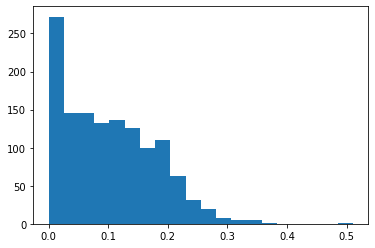

In [28]:
plt.hist(dist, bins=20)

In [25]:
def cm_simple_analysis(cm, thresh):
    R = cm.regrets.copy()
    R = R[R.max(axis=1) > thresh]
    pct = R.shape[0] / cm.regrets.shape[0]
    print("%0.2f of the databases have significant r^2" % (pct*100) )
    print("Best-performer percentages:")
    print(pd.value_counts(R.idxmax(axis=1)) / R.shape[0])
    print("Algorithm average performance:")
    print(R.mean(axis=0))
    M = R.values.copy()
    M.sort(axis=1)
    dist = (M[:, -1] - M[:, -2])
    _ = plt.hist(dist, bins=20)

61.95 of the databases have significant r^2
Best-performer percentages:
1          0.667179
10.0       0.221368
0.1        0.100692
10000.0    0.004612
1000.0     0.003075
100.0      0.001537
0.01       0.000769
0.001      0.000769
dtype: float64
Algorithm average performance:
0.0001    -0.365271
0.001     -0.348175
0.01      -0.237573
0.1        0.001833
1          0.121946
10.0      -0.257781
100.0     -0.365170
1000.0    -0.302999
10000.0   -0.309073
dtype: float64


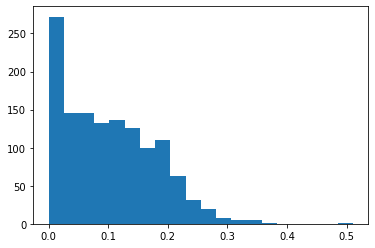

In [26]:
cm_simple_analysis(acm, thresh=0.03)

62.10 of the databases have significant r^2
Best-performer percentages:
1          0.575153
10.0       0.324387
0.1        0.088957
10000.0    0.004601
1000.0     0.003834
100.0      0.001534
0.01       0.001534
dtype: float64
Algorithm average performance:
0.0001    -0.382291
0.001     -0.364118
0.01      -0.252233
0.1       -0.029497
1          0.099356
10.0      -0.213340
100.0     -0.394688
1000.0    -0.314432
10000.0   -0.321598
dtype: float64


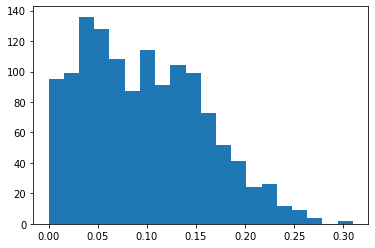

In [13]:
cm_simple_analysis(mcm, thresh=0.03)

### Experiment

##### Setup
We have three dataset lists, each containing slices of a dataset. We train train four
choicemakers in method inspired by cross-validation:
Choicemaker i uses all partitions except for i as training data and is then tested on list i.
Testing involves computing the error for each of the base algorithms, the choicemaker, ERM,
and non-private cross-validation, averaged over each dataset in list i.

In [42]:
"""
{dbname}_test_cm contains all databases which are not named {dbname} as training data.
"""

adult_test_cm = DTChoice(lending_data + magic_data, DBMetafeatures(), 
                       alg_list(),
                       1.0-pd.concat((lcm.regrets, mcm.regrets), ignore_index=True))
adult_test_cm.model = tree.DecisionTreeClassifier(min_samples_leaf=10, max_depth=3)
adult_test_cm.retrain_model()

lending_test_cm = DTChoice(adult_data + magic_data, DBMetafeatures(), 
                       alg_list(),
                       1.0-pd.concat((acm.regrets, mcm.regrets), ignore_index=True))
lending_test_cm.model = tree.DecisionTreeClassifier(min_samples_leaf=10, max_depth=3)
lending_test_cm.retrain_model()

magic_test_cm = DTChoice(adult_data + lending_data, DBMetafeatures(), 
                       alg_list(),
                       1.0-pd.concat((acm.regrets, lcm.regrets), ignore_index=True))
magic_test_cm.model = tree.DecisionTreeClassifier(min_samples_leaf=10, max_depth=3)
magic_test_cm.retrain_model()

In [191]:
def get_cm(data, cm):
    algos = []
    rsq = []
    for db in data:
        alg = cm.choose(db, 0.2)
        algos.append(alg.name)
        rsq.append(alg.error(db))
    return (algos, rsq)

In [181]:
if rerun_exps[0]:
    lending_algos, lending_rsq = get_cm(lending_data, lending_test_cm)
    pickle.dump(lending_rsq, open(data_folder+'lending_exp1.pkl', 'wb'))
else:
    lending_rsq = pickle.load(open(data_folder+'lending_exp1.pkl', 'rb'))

In [192]:
if rerun_exps[1]:
    adult_algos, adult_rsq = get_cm(adult_data, adult_test_cm)
    pickle.dump(adult_rsq, open(data_folder + 'adult_exp1.pkl', 'wb'))
else:
    adult_rsq = pickle.load(open(data_folder+'adult_exp1.pkl', 'rb'))

In [195]:
if rerun_exps[2]:
    magic_algos, magic_rsq = get_cm(magic_data, magic_test_cm)
    pickle.dump(magic_rsq, open(data_folder + 'magic_exp1.pkl', 'wb'))
else:
    magic_rsq = pickle.load(open(data_folder + 'magic_exp1.pkl', 'rb'))

In [206]:
lending_regrets = lcm.regrets.copy()
lending_regrets['cm'] = lending_rsq
#lending_regrets = lending_regrets.loc[~np.all(lending_regrets < 0, axis=1), : ]
adult_regrets = acm.regrets.copy()
adult_regrets['cm'] = adult_rsq
#adult_regrets = adult_regrets.loc[~np.all(adult_regrets < 0, axis=1), : ]
magic_regrets = mcm.regrets.copy()
magic_regrets['cm'] = magic_rsq
#magic_regrets = magic_regrets.loc[~np.all(magic_regrets < 0, axis=1), : ]

In [141]:
col = lending_rsq.copy()

In [229]:
def post_transform(regrets, epsilons):
    idxs = ~np.all(regrets < 0, axis=1)
    regrets = regrets.loc[idxs, :]
    return regrets.groupby(epsilons[idxs]).median()

In [230]:
post_transform(magic_regrets, epsilon_test)

,0.0001,0.001,0.01,0.1,1,10.0,100.0,1000.0,10000.0,cm
1.0,-0.186946,-0.163226,-0.044318,0.046323,-0.218795,-0.290189,-0.314153,-0.275276,-0.307673,0.013996
3.0,-0.189276,-0.182278,-0.143457,0.012201,0.103419,-0.307900,-0.330165,-0.312988,-0.309793,0.078634
5.0,-0.191690,-0.186435,-0.158517,-0.008546,0.115810,-0.806056,-0.284797,-0.289572,-0.286650,0.111058
7.0,-0.190840,-0.184542,-0.158241,-0.013472,0.112580,0.091940,-0.291256,-0.286172,-0.282092,0.114059
10.0,-0.191604,-0.186614,-0.164720,-0.019860,0.108283,0.163165,-0.573039,-0.274307,-0.288403,0.114891


In [231]:
post_transform(lending_regrets, epsilon_test)

,0.0001,0.001,0.01,0.1,1,10.0,100.0,1000.0,10000.0,cm
1.0,0.000202,0.000765,0.003257,0.010984,-0.420368,-0.569341,-0.610002,-0.613704,-0.663836,0.003566
3.0,-0.187985,-0.173909,-0.086523,0.005418,0.016101,-0.623222,-0.716277,-0.726990,-0.734989,0.017261
5.0,-0.188229,-0.180868,-0.136063,-0.009909,0.025039,-0.920637,-0.642271,-0.669099,-0.677193,0.022802
7.0,-0.188137,-0.180308,-0.139698,-0.008442,0.032312,-0.054930,-0.579238,-0.671032,-0.686554,0.026424
10.0,-0.188859,-0.182975,-0.148705,-0.017598,0.029497,0.014753,-0.754238,-0.598877,-0.645101,0.028485


In [232]:
post_transform(adult_regrets, epsilon_test)

,0.0001,0.001,0.01,0.1,1,10.0,100.0,1000.0,10000.0,cm
1.0,-0.186820,-0.164112,-0.041788,0.067628,-0.199005,-0.292887,-0.278836,-0.296259,-0.306067,0.026175
3.0,-0.188860,-0.181424,-0.141936,0.026331,0.111833,-0.295174,-0.308745,-0.335546,-0.310741,0.069187
5.0,-0.190325,-0.184119,-0.155458,0.020779,0.137627,-0.844398,-0.270168,-0.275768,-0.280373,0.135453
7.0,-0.189137,-0.183361,-0.157405,0.008986,0.141824,0.020912,-0.258166,-0.244448,-0.240435,0.142340
10.0,-0.192465,-0.186808,-0.162493,-0.006754,0.148774,0.150522,-0.572003,-0.222768,-0.242631,0.146390


In [233]:
np.where(epsilon_list == 5.0)

(array([  20,   21,   22,   23,   24,   25,   26,   27,   28,   29,   70,
          71,   72,   73,   74,   75,   76,   77,   78,   79,  120,  121,
         122,  123,  124,  125,  126,  127,  128,  129,  170,  171,  172,
         173,  174,  175,  176,  177,  178,  179,  220,  221,  222,  223,
         224,  225,  226,  227,  228,  229,  270,  271,  272,  273,  274,
         275,  276,  277,  278,  279,  320,  321,  322,  323,  324,  325,
         326,  327,  328,  329,  370,  371,  372,  373,  374,  375,  376,
         377,  378,  379,  420,  421,  422,  423,  424,  425,  426,  427,
         428,  429,  470,  471,  472,  473,  474,  475,  476,  477,  478,
         479,  520,  521,  522,  523,  524,  525,  526,  527,  528,  529,
         570,  571,  572,  573,  574,  575,  576,  577,  578,  579,  620,
         621,  622,  623,  624,  625,  626,  627,  628,  629,  670,  671,
         672,  673,  674,  675,  676,  677,  678,  679,  720,  721,  722,
         723,  724,  725,  726,  727, 

In [249]:
[val.error(adult_data[870]) for key,val in alg_list().items()]

[-0.9926412358891725,
 -0.9738994863882271,
 -0.8048509971967794,
 -0.18696152841980318,
 0.08824330657789015,
 -1.8055201643295664,
 -0.18973242974096038,
 -0.19145434355423463,
 -0.35848883010801735]

In [103]:
#TODO: Make graphs!
#TODO: Update Kamalika's method (change it to a better one?)

In [ ]:
"""
do_linegraph plots the nice-looking line graph for different epsilons.

tst: a pandas dataframe indexed by epsilon values and columns themselves are algorithm performances.
"""
def do_linegraph(tst):
    fig, axis=plt.subplots()
    for col in tst:
        axis.plot(np.array(tst[col].index), tst[col], 'o-', label=col)
    #axis.plot(tst.index, tst['cm'], 'o-', label='C_reg')
    axis.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),  shadow=True, ncol=3)
    axis.set_ylabel('Percent correct')
    axis.set_title('Percent correctly classified by Jostle, competitor, and baseline')
    axis.set_xscale('log')

### Kamalika's method

In [29]:
def get_dp_logistic_regression(X_train, y_train, X_test, y_test, 
                             epsilon, ratio, param_list):
    train_eps = epsilon*ratio
    validation_eps = epsilon-train_eps
    #Begin validation
    utils = []
    for C in param_list:
        model = DPLogisticRegression(train_eps, C=C, K=1.02, fit_intercept=True)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        score = (preds == y_test).sum() / y_test.size
        beta = max(1.0/y_test.size, 1.0/y_train.size)
        score += np.random.exponential(1/validation_eps)*beta*2
        utils.append(score)
    return np.array(utils).argmax()

In [30]:
def test_db_MRE(data_test, ratio=0.8, splits=5, do_private=True):
    kf = model_selection.KFold(splits)
    avgs = []
    for db in data_test:
        avg = 0
        for train_idx, test_idx in kf.split(db.X):
            X_val = db.X.iloc[test_idx]
            y_val = db.y.iloc[test_idx]
            X_train = db.X.iloc[train_idx]
            y_train = db.y.iloc[train_idx]
            X_ttrain, X_ttest, y_ttrain, y_ttest = model_selection.train_test_split(X_train, y_train, test_size=0.2)
            if pd.Series.nunique(y_ttrain) == 1:
                avg += 1.0
                continue
            if do_private:
                eps = db.epsilon
            else:
                eps=100
            idx = get_dp_logistic_regression(X_ttrain, y_ttrain, X_ttest, y_ttest, eps, ratio, C_list)
            alg = DP(C_list[idx])
            if do_private:
                alg.model.set_epsilon(eps - (1-ratio)*eps)
            else:
                alg.model.set_epsilon(100)
            alg.model.fit(X_ttrain, y_ttrain)
            y_hat = alg.model.predict(X_val)
            avg += (y_hat == y_val).sum() / y_val.size
        avg /= splits
        avgs.append(1.0-avg)
    return np.array(avgs)

In [31]:
"""Performance of ERM on each dataset slice. We generate the test sets freshly because
the choicemaker alters epsilon yet we need the same amount of budget.
"""
(adult_data_test, default_data_test, lending_data_test, magic_data_test) = get_test_set()
adult_perf = test_db_MRE(adult_data_test)
lending_perf = test_db_MRE(lending_data_test)
default_perf = test_db_MRE(default_data_test)
magic_perf = test_db_MRE(magic_data_test)

In [32]:
"""Performance of non-private cross-validation on each dataset partition. """
(adult_data_test, default_data_test, lending_data_test, magic_data_test) = get_test_set()
adult_perf_non = test_db_MRE(adult_data_test, do_private=False)
lending_perf_non = test_db_MRE(lending_data_test, do_private=False)
default_perf_non = test_db_MRE(default_data_test, do_private=False)
magic_perf_non = test_db_MRE(magic_data_test, do_private=False)

In [33]:
adult_errors['Stability'] = adult_perf
adult_errors['NonPrivate'] = adult_perf_non
adult_errors['eps'] = epsilons
lending_errors['Stability'] = lending_perf
lending_errors['NonPrivate'] = lending_perf_non
lending_errors['eps'] = epsilons
default_errors['Stability'] = default_perf
default_errors['NonPrivate'] = default_perf_non
default_errors['eps'] = epsilons
magic_errors['Stability'] = magic_perf
magic_errors['NonPrivate'] = magic_perf_non
magic_errors['eps'] = epsilons

In [41]:
""" Code for dumping all of the errors to a files
pickle.dump(adult_errors, open('log_regression_metadata/adult_results.pkl', 'wb'))
pickle.dump(lending_errors, open('log_regression_metadata/lending_results.pkl', 'wb'))
pickle.dump(default_errors, open('log_regression_metadata/default_results.pkl', 'wb'))
pickle.dump(magic_errors, open('log_regression_metadata/magic_results.pkl', 'wb'))
"""

In [56]:
adult_errors2['Stability'] = adult_perf
adult_errors2['NonPrivate'] = adult_perf_non
adult_errors2['eps'] = epsilons

In [80]:
tst = adult_errors2.groupby('eps').mean()

In [60]:
tst = pd.concat([adult_errors, lending_errors, default_errors, magic_errors], ignore_index=True).groupby('eps').mean()

In [35]:
import matplotlib.patches as mpatches

Text(0.5,1,'Errors of Stability, C_reg, and NonPrivate over 4 datasets')

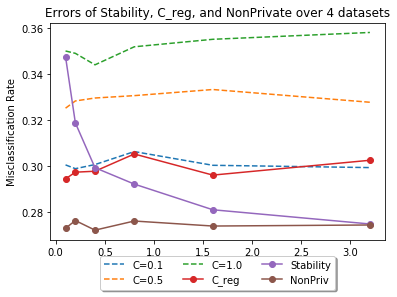

In [81]:
fig, axis=plt.subplots()
for a in alg_list:
    axis.plot(tst.index, tst[a.name], '--', label='C=%s' % a.name)
axis.plot(tst.index, tst['cm'], 'o-', label='C_reg')
axis.plot(tst.index, tst['Stability'], 'o-', label='Stability')
axis.plot(tst.index, tst['NonPrivate'], 'o-', label='NonPriv')
axis.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),  shadow=True, ncol=3)
axis.set_ylabel('Misclassification Rate')
axis.set_title('Errors of Stability, C_reg, and NonPrivate over 4 datasets')

In [68]:
adult_cm.regrets.mean(axis=0)

0.1    0.300858
0.5    0.328354
1.0    0.349988
dtype: float64

In [77]:
adult_data_test

 ...]

In [79]:
adult_data_test[0]